# Deep Hyper Tutorial
https://deephyper.readthedocs.io/en/latest/tutorials/hps_dl_basic.html

We will illustrate DeepHyper HPS using a regression example. We generate synthetic data according to `y=x^T x`
 for random `N`-dimensional input vectors `x`. Our regression model is a multilayer perceptron with 1 hidden layer, implemented in Keras. Using HPS, we will then tune the model hyperparameters to optimize the validation 
`R^2` metric.

In [4]:
import os
import numpy as np

np.random.seed(2018)


def load_data(dim=10, a=-50, b=50, prop=0.80, size=10000):
    """Generate a random distribution of data for polynome_2 function: -SUM(X**2) where "**" is an element wise operator in the continuous range [a, b].

    Args:
        dim (int): size of input vector for the polynome_2 function.
        a (int): minimum bound for all X dimensions.
        b (int): maximum bound for all X dimensions.
        prop (float): a value between [0., 1.] indicating how to split data between training set and validation set. `prop` corresponds to the ratio of data in training set. `1.-prop` corresponds to the amount of data in validation set.
        size (int): amount of data to generate. It is equal to `len(training_data)+len(validation_data).

    Returns:
        tuple(tuple(ndarray, ndarray), tuple(ndarray, ndarray)): of Numpy arrays: `(train_X, train_y), (valid_X, valid_y)`.
    """

    def polynome_2(x):
        return -sum([x_i ** 2 for x_i in x])

    d = b - a
    x = np.array([a + np.random.random(dim) * d for i in range(size)])
    y = np.array([[polynome_2(v)] for v in x])

    sep_index = int(prop * size)
    train_X = x[:sep_index]
    train_y = y[:sep_index]

    valid_X = x[sep_index:]
    valid_y = y[sep_index:]

    print(f"train_X shape: {np.shape(train_X)}")
    print(f"train_y shape: {np.shape(train_y)}")
    print(f"valid_X shape: {np.shape(valid_X)}")
    print(f"valid_y shape: {np.shape(valid_y)}")
    return (train_X, train_y), (valid_X, valid_y)


if __name__ == "__main__":
    load_data()

train_X shape: (8000, 10)
train_y shape: (8000, 1)
valid_X shape: (2000, 10)
valid_y shape: (2000, 1)


train_X shape: (8000, 10)
train_y shape: (8000, 1)
valid_X shape: (2000, 10)
valid_y shape: (2000, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                110       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
125/125 [==============================] - 2s 6ms/step - loss: 72685077.2698 - r2: -12.6876 - val_loss: 65497080.0000 - val_r2: -10.4848
Epoch 2/1000
125/125 [==============================] - 0s 2ms/step - loss: 59855892.4762 - r2: -10.4179 - val_loss: 47295512.0000 - val_r2: -7.3174
Epoch 3/1000
125/125 [==============================] - 0s 2ms/step - loss: 41860799.6825 - r2: -7.0476 - val_loss: 288

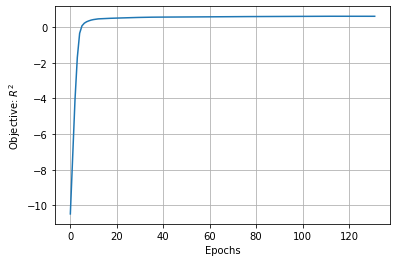

In [13]:
import numpy as np
import keras.backend as K
import keras
from keras.callbacks import EarlyStopping
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import RMSprop

import os
import sys

here = os.path.dirname(os.path.abspath("__file__"))
sys.path.insert(0, here)


def r2(y_true, y_pred): # Like loss function
    SS_res = keras.backend.sum(keras.backend.square(y_true - y_pred), axis=0)
    SS_tot = keras.backend.sum(
        keras.backend.square(y_true - keras.backend.mean(y_true, axis=0)), axis=0
    )
    output_scores = 1 - SS_res / (SS_tot + keras.backend.epsilon())
    r2 = keras.backend.mean(output_scores)
    return r2


HISTORY = None


def run(point):
    """
    point: dictionary of tunable parameters
    """
    global HISTORY
    (x_train, y_train), (x_valid, y_valid) = load_data()
    
    if point["activation"] == "identity":
        point["activation"] = None
    	
    model = Sequential()
    model.add(
        Dense(
            point["units"],
            activation=point["activation"],
            input_shape=tuple(np.shape(x_train)[1:]),
        )
    )
    model.add(Dense(1))

    model.summary()

    model.compile(loss="mse", optimizer=RMSprop(lr=point["lr"]), metrics=[r2])

    history = model.fit(
        x_train,
        y_train,
        batch_size=64,
        epochs=1000,
        verbose=1,
        callbacks=[EarlyStopping(monitor="val_r2", mode="max", verbose=1, patience=10)],
        validation_data=(x_valid, y_valid),
    )

    HISTORY = history.history

    return history.history["val_r2"][-1]


if __name__ == "__main__":
    point = {"units": 10, "activation": "relu", "lr": 0.01}
    objective = run(point)
    print("objective: ", objective)
    import matplotlib.pyplot as plt

    plt.plot(HISTORY["val_r2"])
    plt.xlabel("Epochs")
    plt.ylabel("Objective: $R^2$")
    plt.grid()
    plt.show()
    
# What determines the objective? Looks kind of random... not the largest or the smallest
# Also what is dense and (Dense)?
# Also don't really understand this history.history thing... is it running history twice somehow? Or running history on history?
# Why is my loss function 4 magnitudes smaller than the example in the tutorial?

## Defining the HPS Problem Space
The `run` function in `model_run.py` expects a hyperparameter dictionary with three keys: `units`, `activation`, and `lr`. We define the acceptable ranges for these hyperparameters with the Problem object inside `problem.py`. Hyperparameter ranges are defined using the following syntax:

Discrete integer ranges are generated from a tuple: `(lower: int, upper: int)`

Continous parameters are generated from a tuple: `(lower: float, upper: float)`

Categorical or nonordinal hyperparameters ranges can be given as a list of possible values: `[val1, val2, ...]`

You probably have one or more “reference” sets of hyperparameters that are either hand-crafted or chosen by intuition. To bootstrap the search with these so-called starting points, use the `add_starting_point(...)` method.

*what do they mean "bootstrap"?*

In [14]:
from deephyper.problem import HpProblem

Problem = HpProblem()

# Like .add_argument in parsing
Problem.add_hyperparameter((1, 100), "units")
Problem.add_hyperparameter(["identity", "relu", "sigmoid", "tanh"], "activation")
Problem.add_hyperparameter((0.0001, 1.0), "lr")

Problem.add_starting_point(units=10, activation="identity", lr=0.01)

if __name__ == "__main__":
    print(Problem)

Configuration space object:
  Hyperparameters:
    activation, Type: Categorical, Choices: {identity, relu, sigmoid, tanh}, Default: identity
    lr, Type: UniformFloat, Range: [0.0001, 1.0], Default: 0.50005
    units, Type: UniformInteger, Range: [1, 100], Default: 50


  Starting Point:
{0: {'activation': 'identity', 'lr': 0.01, 'units': 10}}


In [22]:
print(type(Problem))

<class 'deephyper.problem.hyperparameter.HpProblem'>


*we don't know what asynchronous model search means*

In [15]:
# Not sure how to run this line from a jupyter notebook?
deephyper hps ambs --problem hps_demo.polynome2.problem.Problem --run hps_demo.polynome2.model_run.run
Note

SyntaxError: invalid syntax (<ipython-input-15-212eed39b8b3>, line 1)